# Qredo tokenomics simulation - supply, inflation and TVL

### June 2023

- Scenario overview
- Circulating supply
- Yearly inflation rate
- Daily inflation rate
- Supply components (cumulative)
- Supply components (daily)
- TVL rate
- Staker APR
- TVL rate vs. Staker APR
- Staker minimum weekly rewards
- Average rewards per validator
- Validator profit
- Ecosystem fund balance
- Ecosystem fund net flows

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
forecast_length = 365*3
outfolder = os.path.realpath("../data/sim_data")
month_int = 6

## Load data

In [3]:
# load
df_file = os.path.join(outfolder, f"final_sim_df.pickle")
with open(df_file, "rb") as fp:
    df = pickle.load(fp)

# process columns
df["date"] = df["iteration"].apply(lambda x: dt.datetime(2023, 6, 15)+dt.timedelta(days=x)).values
df["tvl_rate"] = df["staking_tvl"]/df["circ_supply"]
df["apr"] = 365.0*(df["total_staking_rewards"]-df["validators_rewards"])/df["staking_tvl"]
df["min_staker_week_reward"] = 2500*7*(df["apr"]/365)
df["av_validator_reward"] = df["validators_rewards"] / df["n_validators"]
df["validator_profit"] = df["av_validator_reward"] * df["token_price"] - 200.0
df["rewards_source_eco_rate"] = df["staking_rewards_ecosystem"]/df["total_staking_rewards"]

# convert units
mill_cols = ["circ_supply", 'day_vested', 'day_locked', 'day_released','day_burned', "ecosystem_fund", "staking_tvl"]
df[mill_cols] = df[mill_cols]/(10**6)
thou_cols = ["validators_rewards", 'total_staking_rewards','staking_rewards_vested',
             'staking_rewards_ecosystem','day_service_fee_locked']
df[thou_cols] = df[thou_cols]/(10**3)

len(df)

2956500

In [4]:
combined_df = df[(df["staking_scenario"]==df["usage_scenario"]) & (df["staking_scenario"]==df["token_scenario"])]

## Scenario Overview

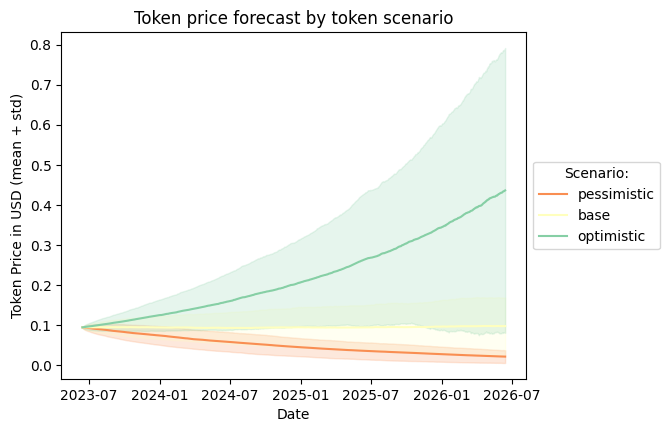

In [5]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="token_price", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Token price forecast by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Token Price in USD (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

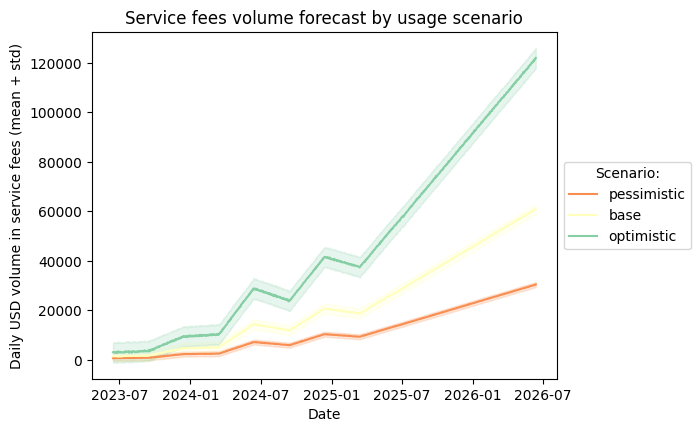

In [6]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="service_fees", hue="usage_scenario", 
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Service fees volume forecast by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Daily USD volume in service fees (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

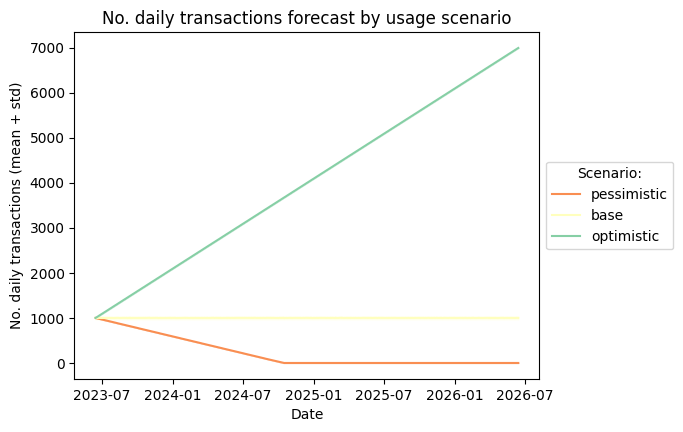

In [7]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="n_txs", hue="usage_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("No. daily transactions forecast by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("No. daily transactions (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

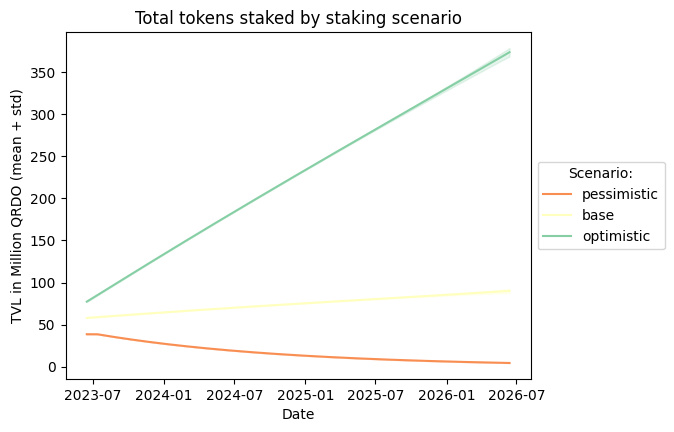

In [8]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="staking_tvl", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Total tokens staked by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("TVL in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

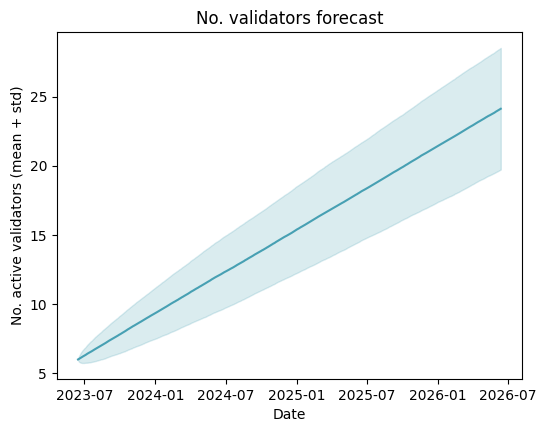

In [9]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="n_validators", errorbar="sd", c='#47a0b3')
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("No. validators forecast") 
plt.xlabel("Date") 
plt.ylabel("No. active validators (mean + std)")
plt.show()

## Circulating supply

In [10]:
df[df["iteration"]==0]["circ_supply"].agg(["mean", "std"])

mean    644.941455
std      30.541956
Name: circ_supply, dtype: float64

In [11]:
df[df["iteration"]==0]["staking_tvl"].agg(["mean", "std"])

mean    58.052356
std     15.802777
Name: staking_tvl, dtype: float64

In [12]:
combined_df[combined_df["iteration"]==0].groupby("token_scenario")["circ_supply"].agg(["mean", "std"])

mean       std
token_scenario                      
base            644.941828  0.007054
optimistic      593.587319  0.013798
pessimistic     696.295633  0.002867

In [13]:
combined_df[combined_df["iteration"]==1094].groupby("token_scenario")["circ_supply"].agg(["mean", "std"])

mean         std
token_scenario                         
base            1166.946041   66.220905
optimistic       907.432325   38.251423
pessimistic     1155.522868  108.234634

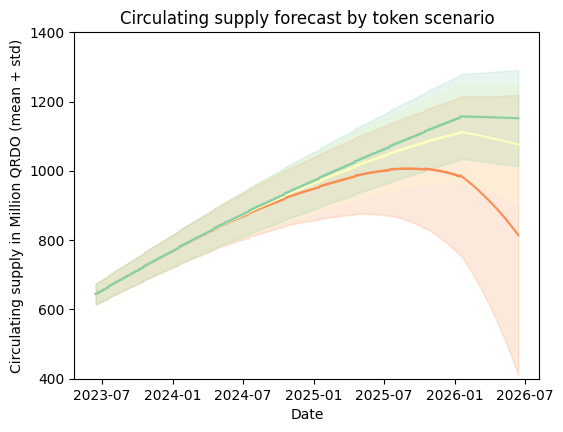

In [14]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="circ_supply", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(400, 1400)
plt.title("Circulating supply forecast by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Circulating supply in Million QRDO (mean + std)")
fig.get_legend().remove()
plt.show()

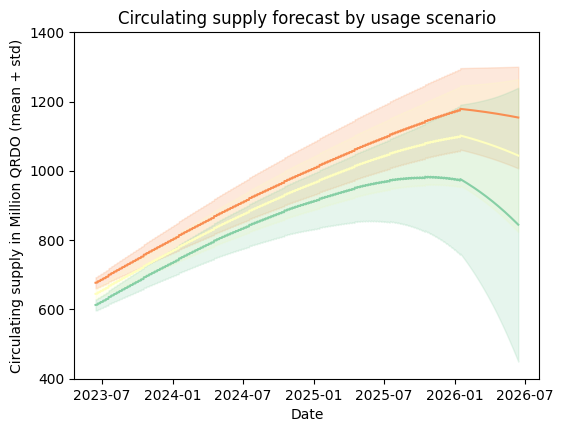

In [15]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="circ_supply", hue="usage_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(400, 1400)
plt.title("Circulating supply forecast by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Circulating supply in Million QRDO (mean + std)")
fig.get_legend().remove()
plt.show()

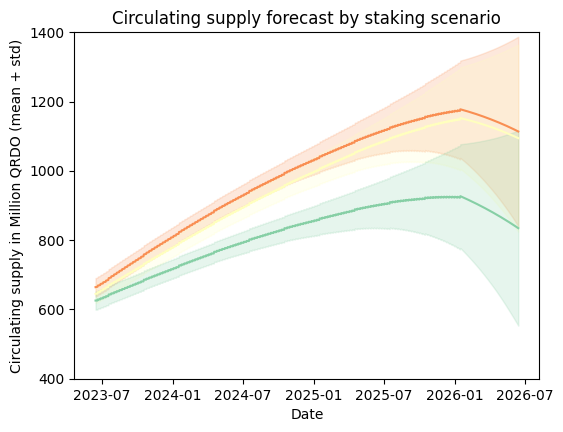

In [16]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="circ_supply", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(400, 1400)
plt.title("Circulating supply forecast by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("Circulating supply in Million QRDO (mean + std)")
fig.get_legend().remove()
plt.show()

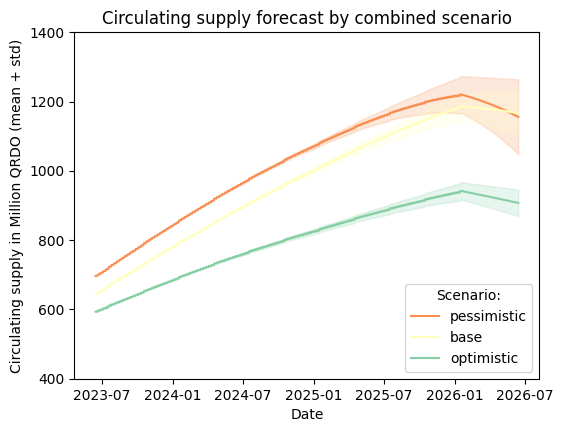

In [17]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="circ_supply", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(400, 1400)
plt.title("Circulating supply forecast by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Circulating supply in Million QRDO (mean + std)")
plt.legend(loc='lower right', title="Scenario:")
plt.show()

## Yearly inflation rate

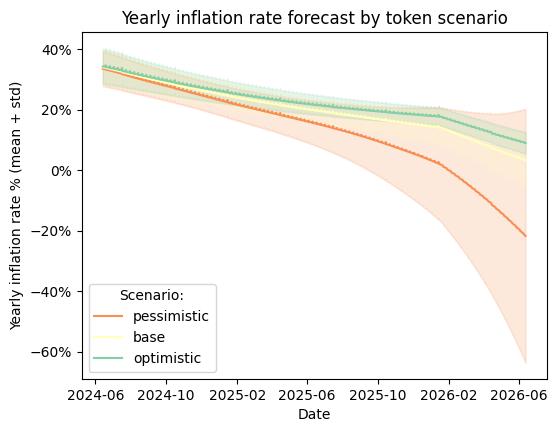

In [18]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="year_inflation", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int-2))
plt.title("Yearly inflation rate forecast by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Yearly inflation rate % (mean + std)")
plt.legend(loc='lower left', title="Scenario:")
plt.show()

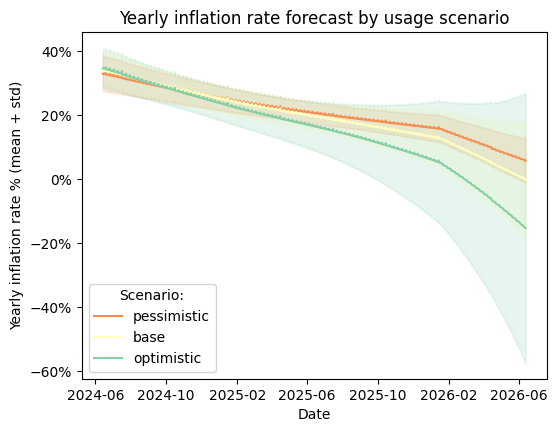

In [19]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="year_inflation", hue="usage_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int-2))
plt.title("Yearly inflation rate forecast by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Yearly inflation rate % (mean + std)")
plt.legend(loc='lower left', title="Scenario:")
plt.show()

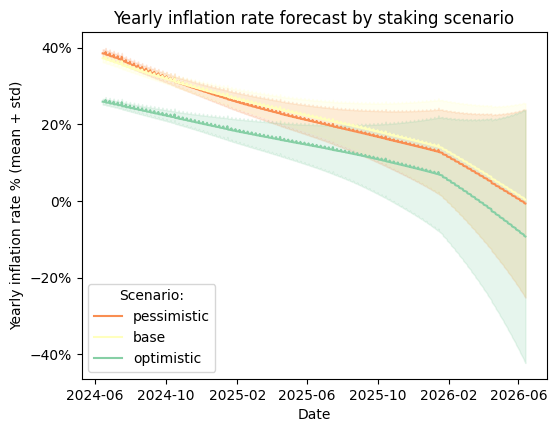

In [20]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="year_inflation", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int-2))
plt.title("Yearly inflation rate forecast by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("Yearly inflation rate % (mean + std)")
plt.legend(loc='lower left', title="Scenario:")
plt.show()

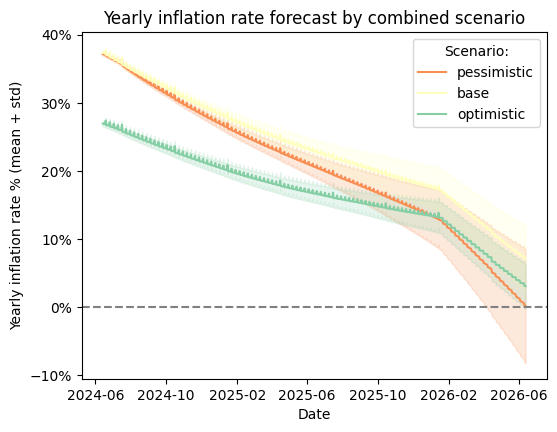

In [21]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="year_inflation", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int-2))
plt.axhline(y=0, color='grey', linestyle='--')
plt.title("Yearly inflation rate forecast by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Yearly inflation rate % (mean + std)")
plt.legend(loc='upper right', title="Scenario:")
plt.show()

## Daily inflation rate

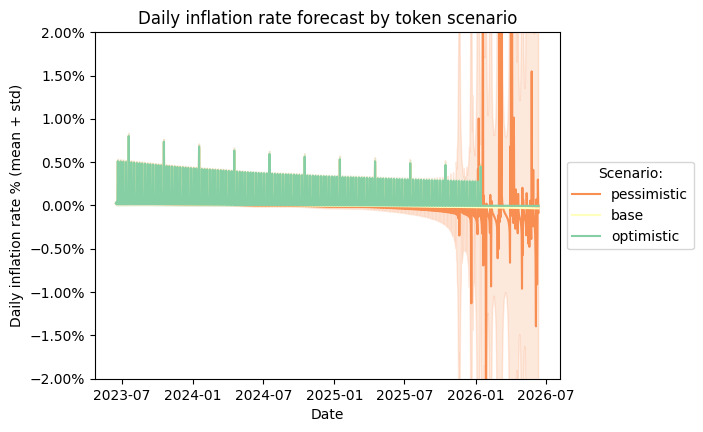

In [22]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="day_inflation", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(-0.02, 0.02)
plt.title("Daily inflation rate forecast by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Daily inflation rate % (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

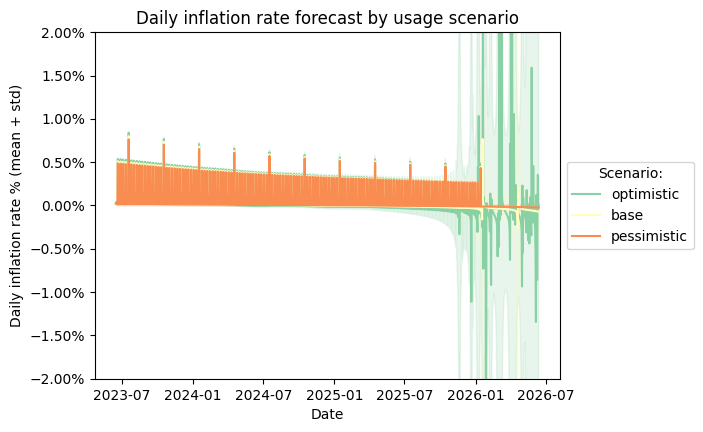

In [23]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df.iloc[::-1], x="date", y="day_inflation", hue="usage_scenario", 
                   errorbar="sd", palette="Spectral_r")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(-0.02, 0.02)
plt.title("Daily inflation rate forecast by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Daily inflation rate % (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

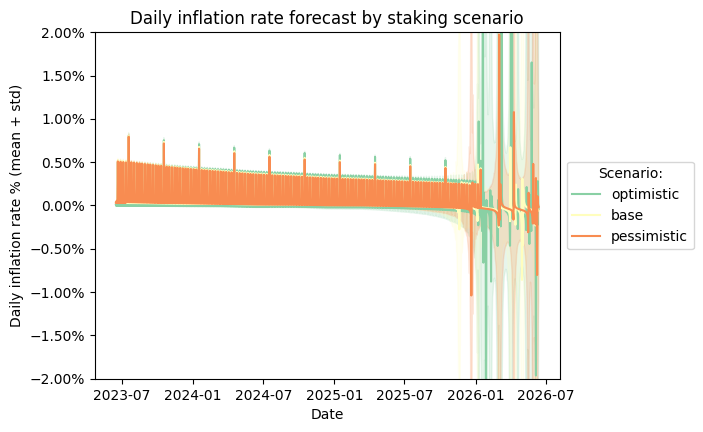

In [24]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df.iloc[::-1], x="date", y="day_inflation", hue="staking_scenario",
                   errorbar="sd", palette="Spectral_r")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(-0.02, 0.02)
plt.title("Daily inflation rate forecast by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("Daily inflation rate % (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

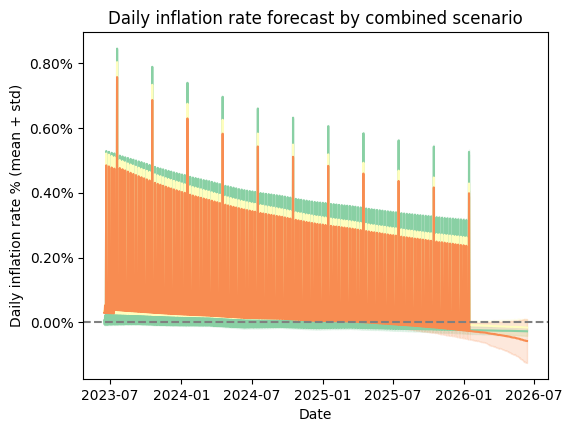

In [25]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df.iloc[::-1], x="date", y="day_inflation", 
                   hue="token_scenario", errorbar="sd", palette="Spectral_r")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.axhline(y=0, color='grey', linestyle='--')
plt.title("Daily inflation rate forecast by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Daily inflation rate % (mean + std)")
fig.get_legend().remove()
plt.show()

## Supply components (cumulative)

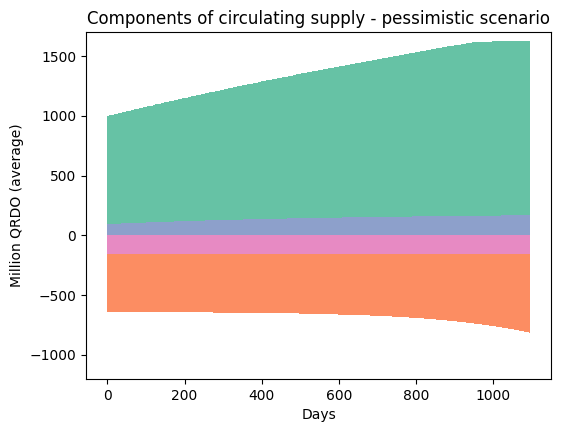

In [26]:
scenario = "pessimistic"
# Data
cols = ['day_burned', 'day_vested', 'day_locked', 'day_released']
filter_df = combined_df[combined_df["token_scenario"]==scenario].copy()
temp_df = filter_df.groupby("iteration")[cols].mean().reset_index()
temp_df['day_burned'] = -temp_df['day_burned']
temp_df['day_locked'] = -temp_df['day_locked']
cum_df = temp_df[cols].cumsum()
release = cum_df['day_released']
vest = cum_df['day_vested'] + release
burn = cum_df["day_burned"]
lock = cum_df['day_locked'] + burn

# Plot
bar_width = 1
plt.figure(figsize=(6,4.5))
plt.bar(temp_df["iteration"], vest, label="Vested", width=bar_width, color="#66c2a5")
plt.bar(temp_df["iteration"], release, label='Released', width=bar_width, color="#8da0cb")
plt.bar(temp_df["iteration"], lock, label="Locked", width=bar_width, color="#fc8d62")
plt.bar(temp_df["iteration"], burn, label="Burned", width=bar_width, color="#e78ac3")
plt.ylabel("Million QRDO (average)")
plt.xlabel("Days")
plt.ylim(-1200, 1700)
plt.title(f"Components of circulating supply - {scenario} scenario")
plt.show()

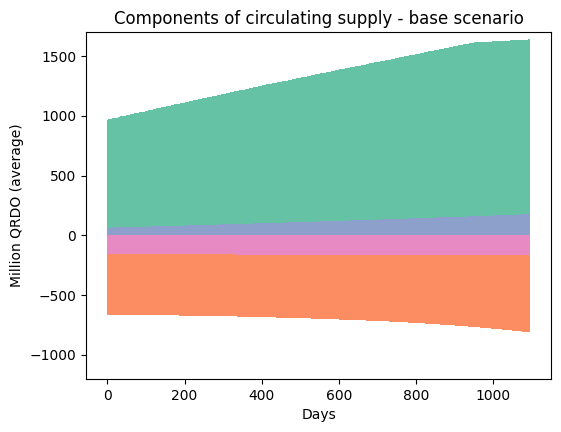

In [27]:
scenario = "base"
# Data
cols = ['day_burned', 'day_vested', 'day_locked', 'day_released']
filter_df = combined_df[combined_df["token_scenario"]==scenario].copy()
temp_df = filter_df.groupby("iteration")[cols].mean().reset_index()
temp_df['day_burned'] = -temp_df['day_burned']
temp_df['day_locked'] = -temp_df['day_locked']
cum_df = temp_df[cols].cumsum()
release = cum_df['day_released']
vest = cum_df['day_vested'] + release
burn = cum_df["day_burned"]
lock = cum_df['day_locked'] + burn

# Plot
bar_width = 1
plt.figure(figsize=(6,4.5))
plt.bar(temp_df["iteration"], vest, label="Vested", width=bar_width, color="#66c2a5")
plt.bar(temp_df["iteration"], release, label='Released', width=bar_width, color="#8da0cb")
plt.bar(temp_df["iteration"], lock, label="Locked", width=bar_width, color="#fc8d62")
plt.bar(temp_df["iteration"], burn, label="Burned", width=bar_width, color="#e78ac3")
plt.ylabel("Million QRDO (average)")
plt.xlabel("Days")
plt.ylim(-1200, 1700)
plt.title(f"Components of circulating supply - {scenario} scenario")
plt.show()

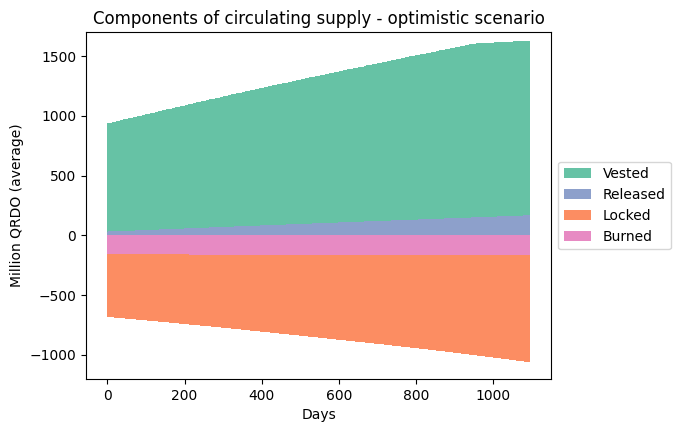

In [28]:
scenario = "optimistic"
# Data
cols = ['day_burned', 'day_vested', 'day_locked', 'day_released']
filter_df = combined_df[combined_df["token_scenario"]==scenario].copy()
temp_df = filter_df.groupby("iteration")[cols].mean().reset_index()
temp_df['day_burned'] = -temp_df['day_burned']
temp_df['day_locked'] = -temp_df['day_locked']
cum_df = temp_df[cols].cumsum()
release = cum_df['day_released']
vest = cum_df['day_vested'] + release
burn = cum_df["day_burned"]
lock = cum_df['day_locked'] + burn

# Plot
bar_width = 1
plt.figure(figsize=(6,4.5))
plt.bar(temp_df["iteration"], vest, label="Vested", width=bar_width, color="#66c2a5")
plt.bar(temp_df["iteration"], release, label='Released', width=bar_width, color="#8da0cb")
plt.bar(temp_df["iteration"], lock, label="Locked", width=bar_width, color="#fc8d62")
plt.bar(temp_df["iteration"], burn, label="Burned", width=bar_width, color="#e78ac3")
plt.ylabel("Million QRDO (average)")
plt.xlabel("Days")
plt.ylim(-1200, 1700)
plt.title(f"Components of circulating supply - {scenario} scenario")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Supply components (daily)

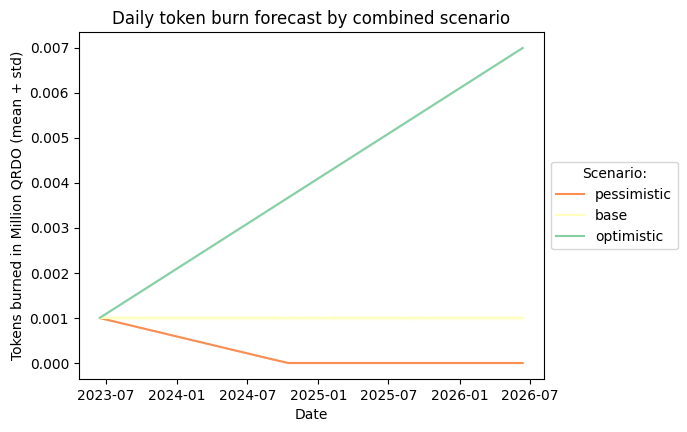

In [29]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df[combined_df["iteration"]>0], x="date", y="day_burned", 
                   hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Daily token burn forecast by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Tokens burned in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

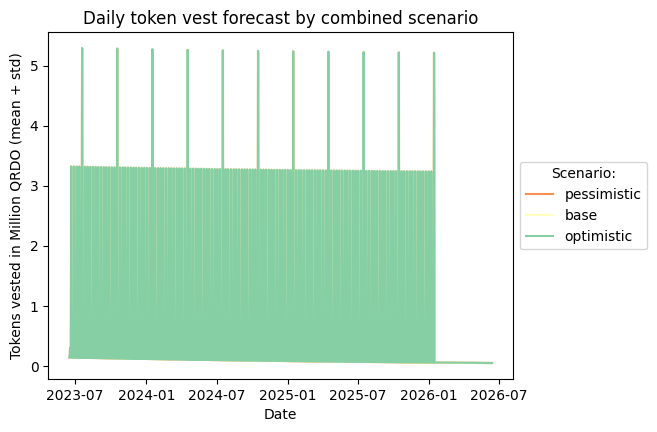

In [30]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df[combined_df["iteration"]>0], x="date", y="day_vested", 
                   hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Daily token vest forecast by combined scenario") 
plt.xlabel("Date")
plt.ylabel("Tokens vested in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

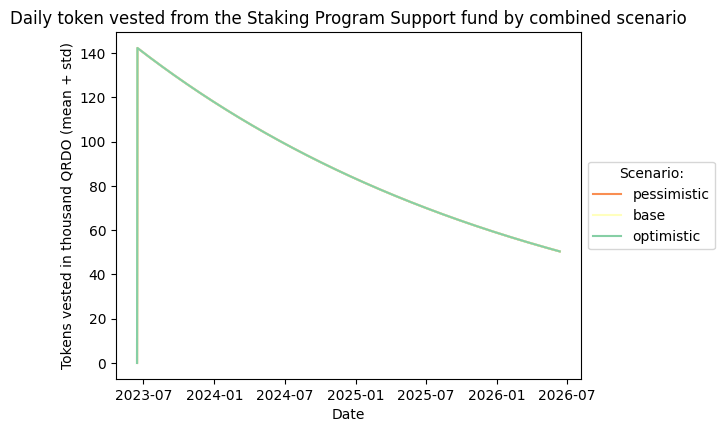

In [31]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="staking_rewards_vested", 
                   hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Daily token vested from the Staking Program Support fund by combined scenario") 
plt.xlabel("Date")
plt.ylabel("Tokens vested in thousand QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

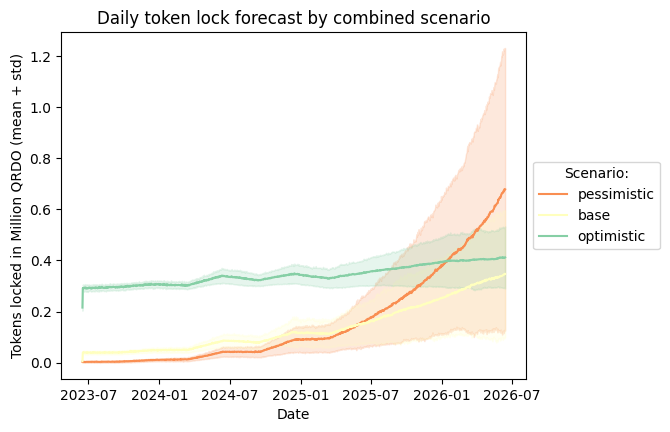

In [32]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df[combined_df["iteration"]>0], x="date", y="day_locked", 
                   hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Daily token lock forecast by combined scenario") 
plt.xlabel("Date")
plt.ylabel("Tokens locked in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

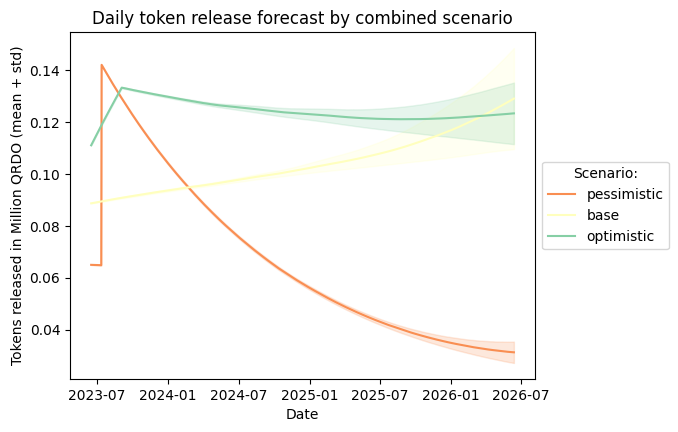

In [33]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df[combined_df["iteration"]>0], x="date", y="day_released", 
                   hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Daily token release forecast by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Tokens released in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

In [34]:
df[df["iteration"]==0][["circ_supply", 'day_vested', 'day_locked', 'day_released','day_burned']].mean()

circ_supply     644.941455
day_vested      905.000000
day_locked      503.057945
day_released     64.000400
day_burned      160.001000
dtype: float64

In [35]:
df[df["iteration"]==0][["circ_supply", 'day_vested', 'day_locked', 'day_released','day_burned']].std()

circ_supply     30.541956
day_vested       0.000000
day_locked      15.802631
day_released    26.132894
day_burned       0.000018
dtype: float64

## TVL rate

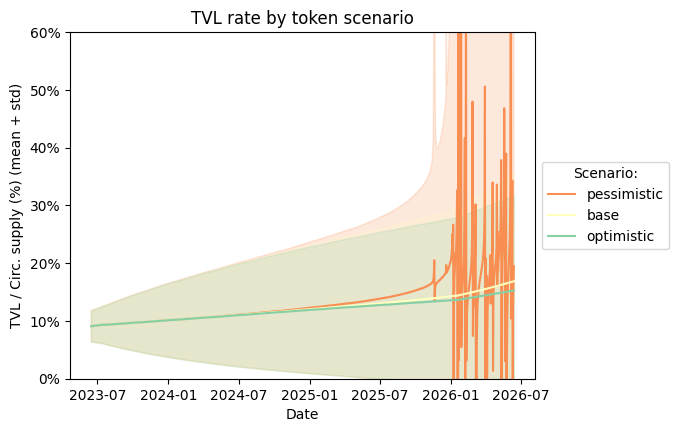

In [36]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="tvl_rate", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(0,0.6)
plt.title("TVL rate by token scenario") 
plt.xlabel("Date") 
plt.ylabel("TVL / Circ. supply (%) (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

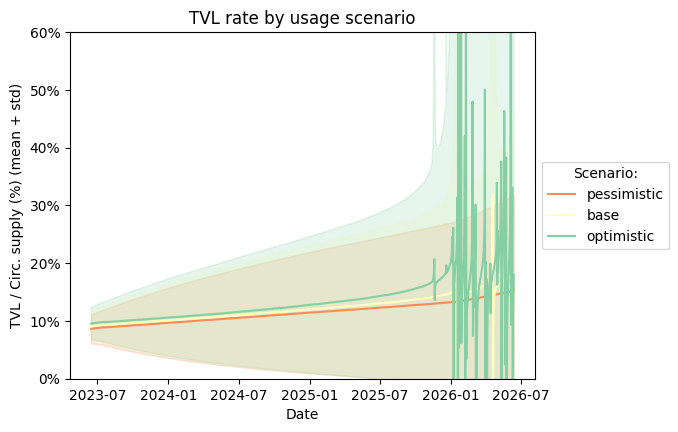

In [37]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="tvl_rate", hue="usage_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(0,0.6)
plt.title("TVL rate by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("TVL / Circ. supply (%) (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

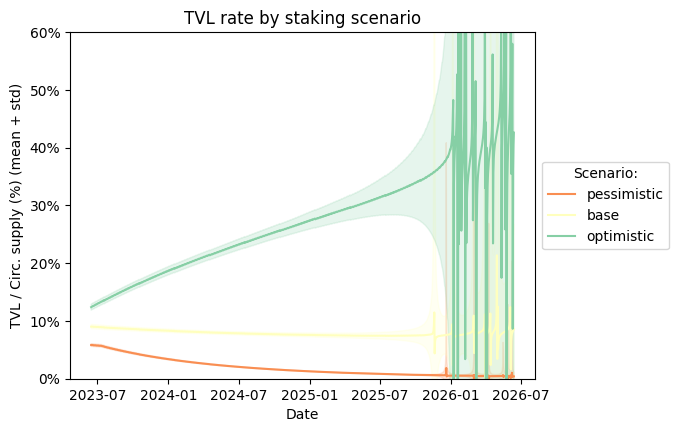

In [38]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="tvl_rate", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(0,0.6)
plt.title("TVL rate by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("TVL / Circ. supply (%) (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

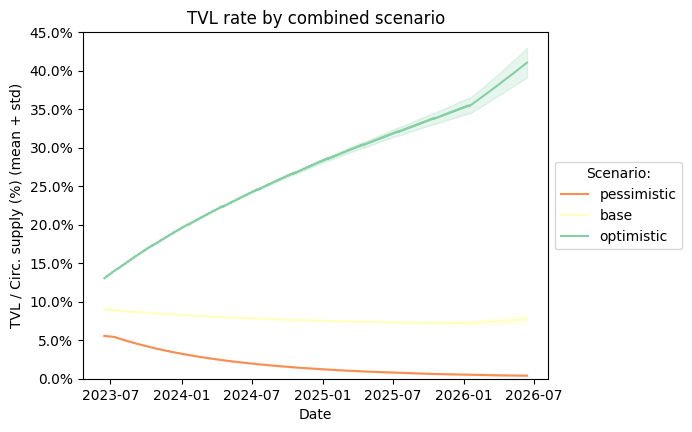

In [39]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="tvl_rate", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("TVL rate by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("TVL / Circ. supply (%) (mean + std)")
plt.ylim(0,0.45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

## Rewards sources

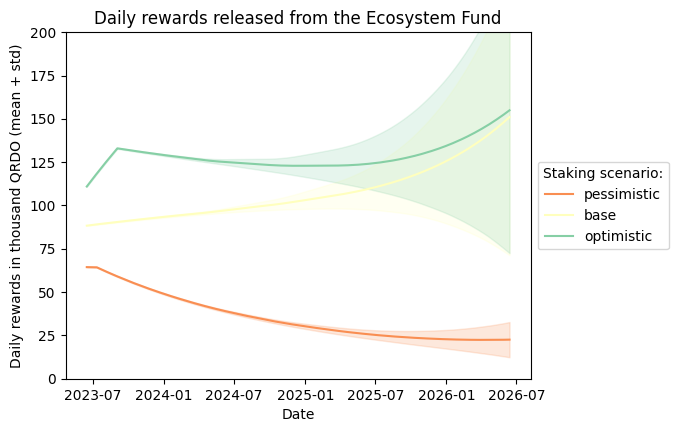

In [40]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df[df["iteration"]>0], x="date", y="staking_rewards_ecosystem", hue="staking_scenario",
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Daily rewards released from the Ecosystem Fund") 
plt.ylim(0,200)
plt.xlabel("Date") 
plt.ylabel("Daily rewards in thousand QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Staking scenario:")
plt.show()

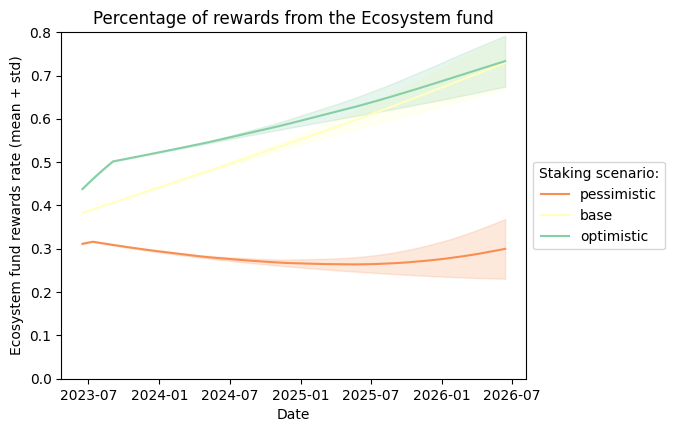

In [41]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df[df["iteration"]>0], x="date", y="rewards_source_eco_rate", hue="staking_scenario",
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Percentage of rewards from the Ecosystem fund") 
plt.ylim(0,0.8)
plt.xlabel("Date") 
plt.ylabel("Ecosystem fund rewards rate (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Staking scenario:")
plt.show()

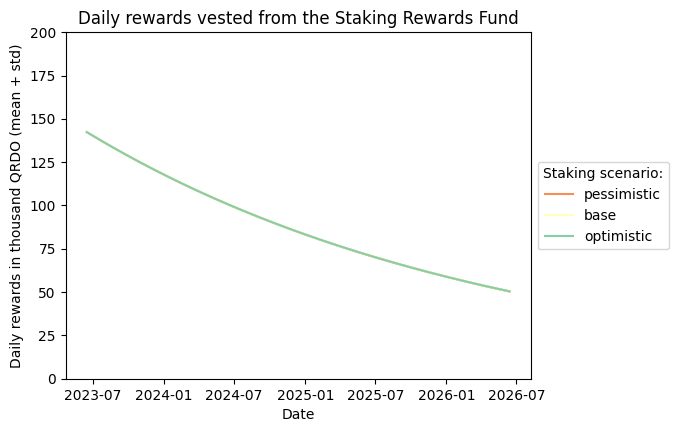

In [42]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df[df["iteration"]>0], x="date", y="staking_rewards_vested", hue="staking_scenario",
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Daily rewards vested from the Staking Rewards Fund") 
plt.ylim(0,200)
plt.xlabel("Date") 
plt.ylabel("Daily rewards in thousand QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Staking scenario:")
plt.show()

## Staker APR

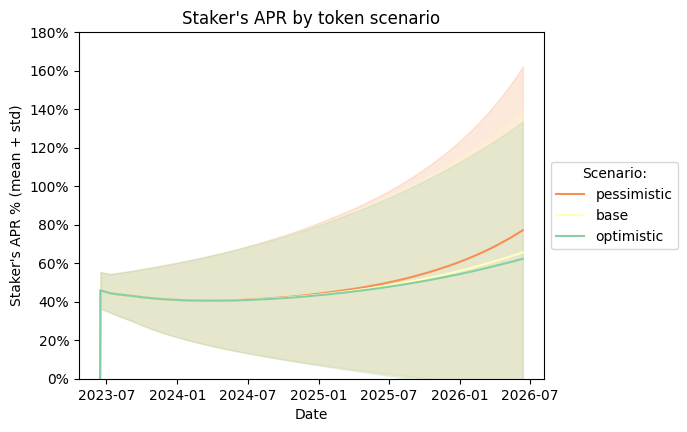

In [43]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="apr", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(0,1.8)
plt.title("Staker's APR by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Staker's APR % (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

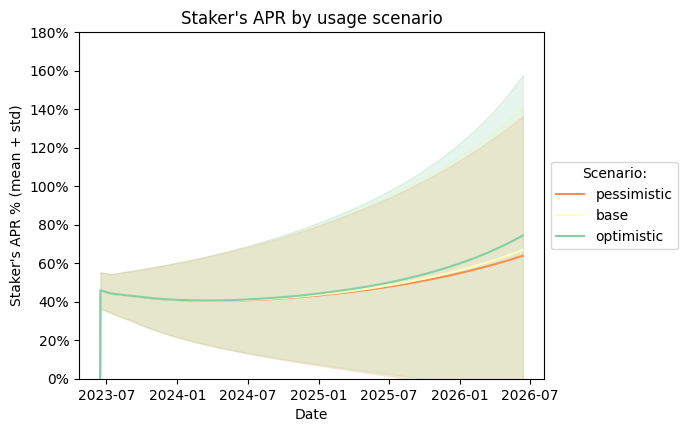

In [44]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="apr", hue="usage_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(0,1.8)
plt.title("Staker's APR by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Staker's APR % (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

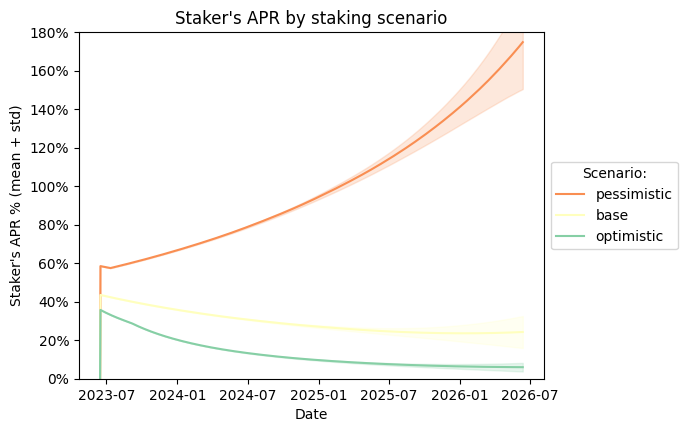

In [45]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="apr", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(0,1.8)
plt.title("Staker's APR by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("Staker's APR % (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

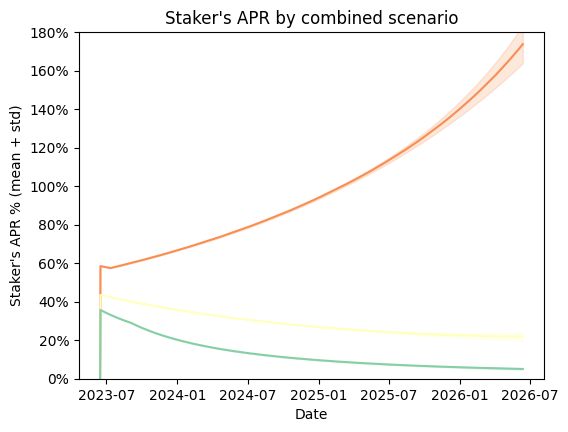

In [46]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="apr", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(0,1.8)
plt.title("Staker's APR by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Staker's APR % (mean + std)")
plt.legend(loc='upper left', title="Scenario:")
fig.get_legend().remove()
plt.show()

In [47]:
df.groupby("staking_scenario")["apr"].mean()

staking_scenario
base           0.293482
optimistic     0.130873
pessimistic    0.996962
Name: apr, dtype: float64

In [48]:
df[df["iteration"]==1].groupby("staking_scenario")["apr"].mean()

staking_scenario
base           0.435169
optimistic     0.357382
pessimistic    0.585028
Name: apr, dtype: float64

In [49]:
df[df["iteration"]==1094].groupby("staking_scenario")["apr"].mean()

staking_scenario
base           0.242670
optimistic     0.059922
pessimistic    1.748387
Name: apr, dtype: float64

## TVL rate vs. Staker APR

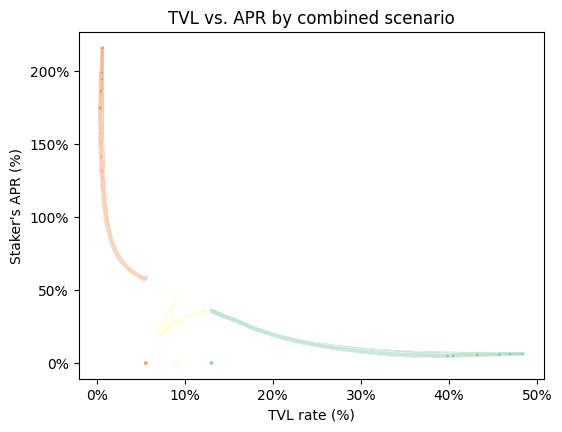

In [50]:
plt.figure(figsize=(6,4.5))
fig = sns.scatterplot(data=combined_df, x="tvl_rate", y="apr",hue="staking_scenario", palette="Spectral", s=6)
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
fig.axes.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
plt.title("TVL vs. APR by combined scenario") 
plt.xlabel("TVL rate (%)") 
plt.ylabel("Staker's APR (%)")
fig.get_legend().remove()
plt.show()

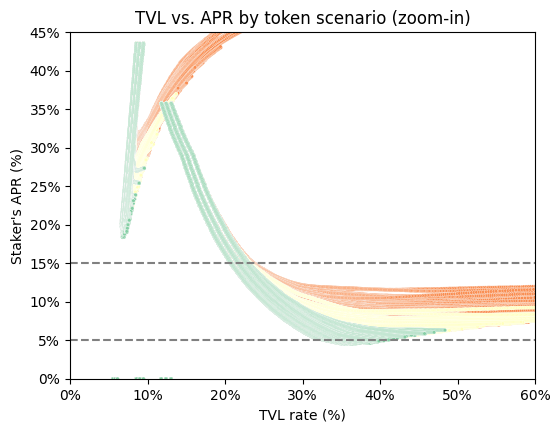

In [51]:
plt.figure(figsize=(6,4.5))
fig = sns.scatterplot(data=df, x="tvl_rate", y="apr",hue="token_scenario", palette="Spectral", s=6)
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
fig.axes.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
plt.xlim(0,0.6)
plt.ylim(0,0.45)
plt.axhline(y=0.05, color='grey', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title("TVL vs. APR by token scenario (zoom-in)") 
plt.xlabel("TVL rate (%)") 
plt.ylabel("Staker's APR (%)")
fig.get_legend().remove()
plt.show()

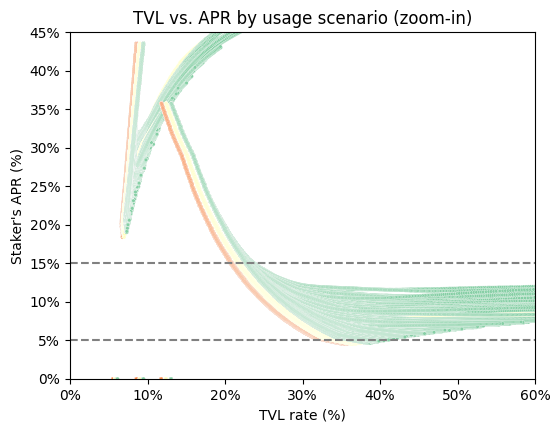

In [52]:
plt.figure(figsize=(6,4.5))
fig = sns.scatterplot(data=df, x="tvl_rate", y="apr",hue="usage_scenario", palette="Spectral", s=6)
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
fig.axes.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
plt.xlim(0,0.6)
plt.ylim(0,0.45)
plt.axhline(y=0.05, color='grey', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title("TVL vs. APR by usage scenario (zoom-in)") 
plt.xlabel("TVL rate (%)") 
plt.ylabel("Staker's APR (%)")
fig.get_legend().remove()
plt.show()

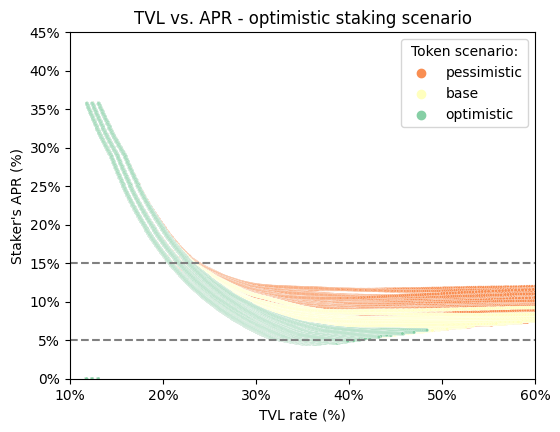

In [53]:
plt.figure(figsize=(6,4.5))
fig = sns.scatterplot(data=df[df["staking_scenario"]=="optimistic"], x="tvl_rate", y="apr",
                      hue="token_scenario", palette="Spectral", s=6)
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
fig.axes.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
plt.xlim(0.1,0.6)
plt.ylim(0,0.45)
plt.axhline(y=0.05, color='grey', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title("TVL vs. APR - optimistic staking scenario") 
plt.xlabel("TVL rate (%)") 
plt.ylabel("Staker's APR (%)")
plt.legend(loc='upper right', title="Token scenario:")
plt.show()

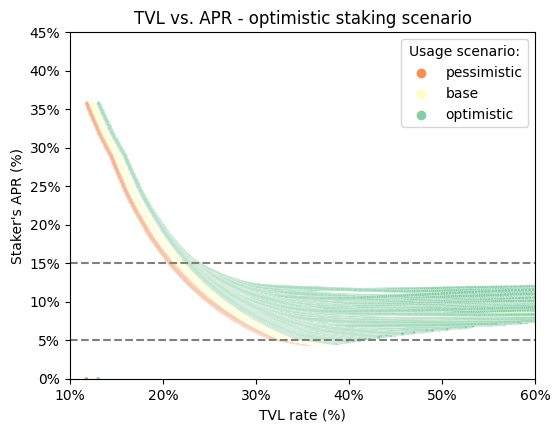

In [54]:
plt.figure(figsize=(6,4.5))
fig = sns.scatterplot(data=df[df["staking_scenario"]=="optimistic"], x="tvl_rate", y="apr",
                      hue="usage_scenario", palette="Spectral", s=6)
fig.axes.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
fig.axes.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
plt.xlim(0.1,0.6)
plt.ylim(0,0.45)
plt.axhline(y=0.05, color='grey', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title("TVL vs. APR - optimistic staking scenario") 
plt.xlabel("TVL rate (%)") 
plt.ylabel("Staker's APR (%)")
plt.legend(loc='upper right', title="Usage scenario:")
plt.show()

## Staker minimum weekly rewards

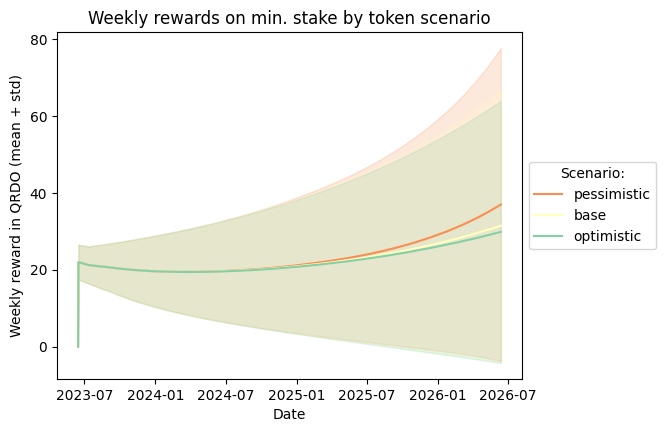

In [55]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="min_staker_week_reward", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Weekly rewards on min. stake by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Weekly reward in QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

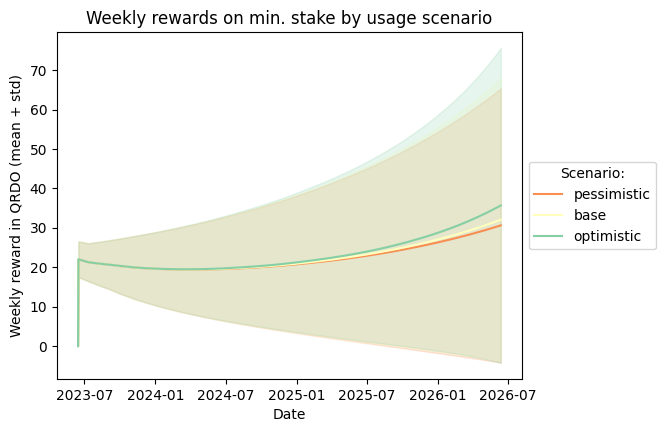

In [56]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="min_staker_week_reward", hue="usage_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Weekly rewards on min. stake by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Weekly reward in QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

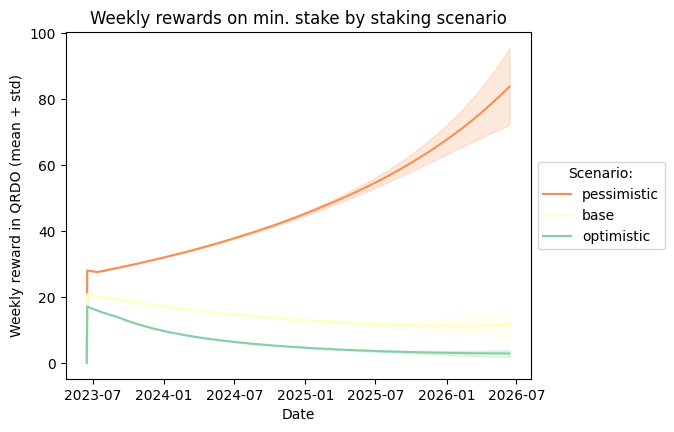

In [57]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="min_staker_week_reward", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Weekly rewards on min. stake by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("Weekly reward in QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

In [58]:
df[df["iteration"]==1].groupby("staking_scenario")["min_staker_week_reward"].mean()

staking_scenario
base           20.864246
optimistic     17.134738
pessimistic    28.049292
Name: min_staker_week_reward, dtype: float64

In [59]:
df[df["iteration"]==1094].groupby("staking_scenario")["min_staker_week_reward"].mean()

staking_scenario
base           11.634850
optimistic      2.872995
pessimistic    83.826771
Name: min_staker_week_reward, dtype: float64

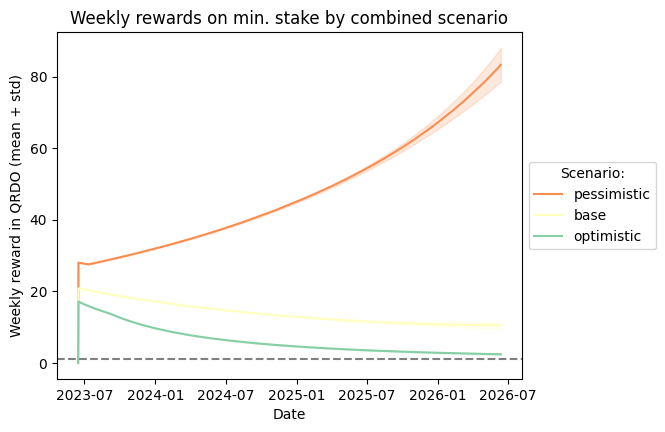

In [60]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="min_staker_week_reward", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Weekly rewards on min. stake by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Weekly reward in QRDO (mean + std)")
plt.axhline(y=1, color='grey', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

## Average rewards per validator

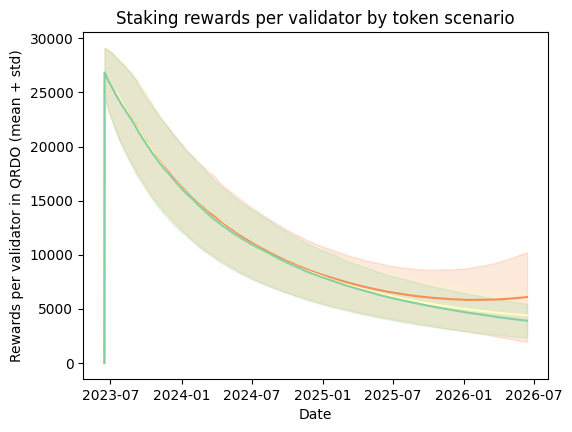

In [61]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="av_validator_reward", hue="token_scenario", 
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Staking rewards per validator by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Rewards per validator in QRDO (mean + std)")
fig.get_legend().remove()
plt.show()

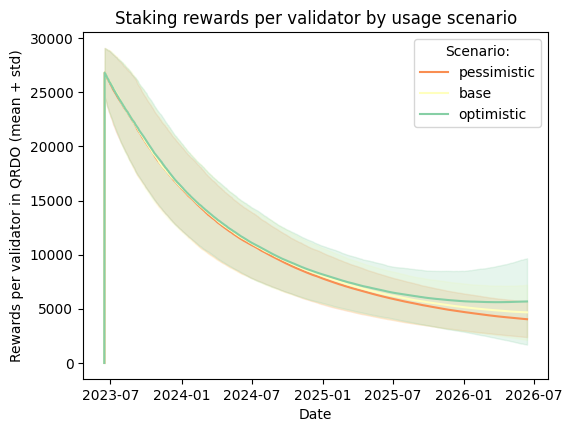

In [62]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="av_validator_reward", hue="usage_scenario", 
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Staking rewards per validator by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Rewards per validator in QRDO (mean + std)")
plt.legend(loc='upper right', title="Scenario:")
plt.show()

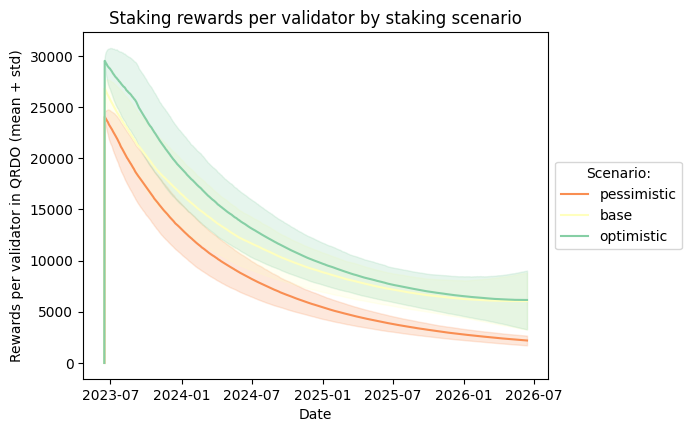

In [63]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="av_validator_reward", hue="staking_scenario", 
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Staking rewards per validator by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("Rewards per validator in QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

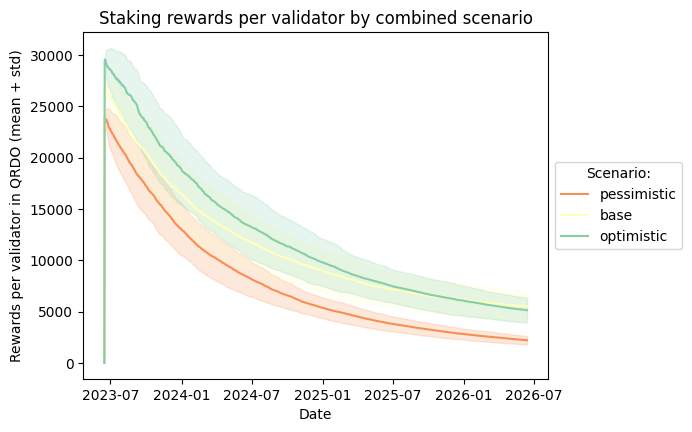

In [64]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="av_validator_reward", hue="staking_scenario", 
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Staking rewards per validator by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Rewards per validator in QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

## Validator profit

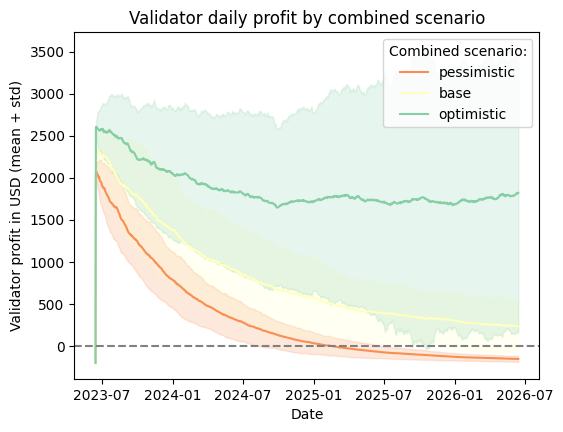

In [65]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="validator_profit", hue="usage_scenario", 
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.axhline(y=0, color='grey', linestyle='--')
plt.title("Validator daily profit by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Validator profit in USD (mean + std)")
plt.legend(loc='upper right', title="Combined scenario:")
plt.show()

In [66]:
combined_df.groupby("staking_scenario")["validator_profit"].mean()

staking_scenario
base            797.542015
optimistic     1871.183650
pessimistic     306.064718
Name: validator_profit, dtype: float64

In [67]:
combined_df[combined_df["iteration"]==1].groupby("staking_scenario")["validator_profit"].mean()

staking_scenario
base           2344.711514
optimistic     2602.879576
pessimistic    2070.974477
Name: validator_profit, dtype: float64

In [68]:
combined_df[combined_df["iteration"]==1092].groupby("staking_scenario")["validator_profit"].mean()

staking_scenario
base            236.444640
optimistic     1821.058037
pessimistic    -151.923248
Name: validator_profit, dtype: float64

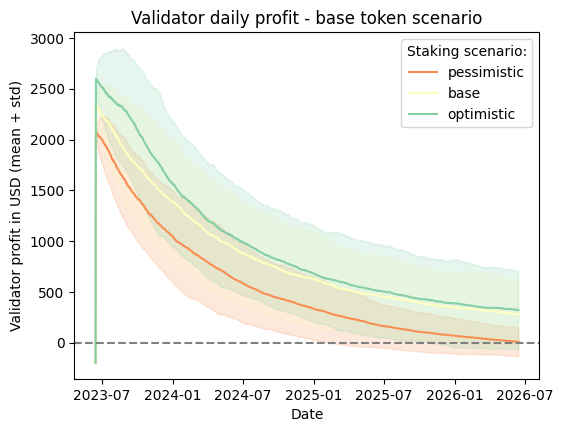

In [69]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df[df["token_scenario"]=="base"], x="date", y="validator_profit", hue="staking_scenario", 
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int)) 
plt.axhline(y=0, color='grey', linestyle='--')
plt.title("Validator daily profit - base token scenario") 
plt.xlabel("Date") 
plt.ylabel("Validator profit in USD (mean + std)")
plt.legend(loc='upper right', title="Staking scenario:")
plt.show()

In [70]:
temp_df = df[df["token_scenario"]=="base"]
temp_df[temp_df["iteration"]==1092].groupby("staking_scenario")["validator_profit"].mean()

staking_scenario
base           280.954405
optimistic     322.098117
pessimistic      9.217779
Name: validator_profit, dtype: float64

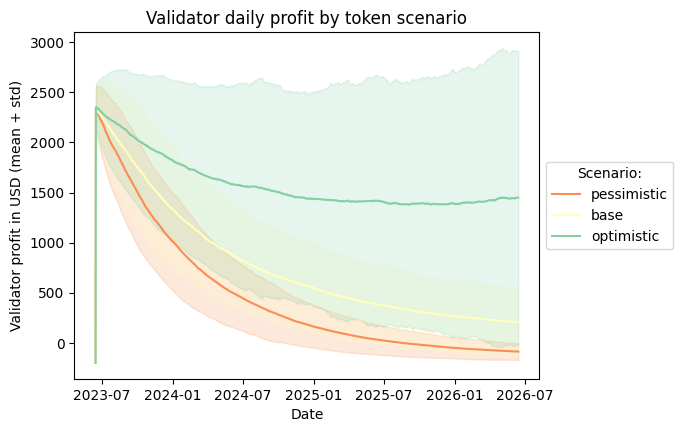

In [71]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="validator_profit", hue="token_scenario", 
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Validator daily profit by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Validator profit in USD (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

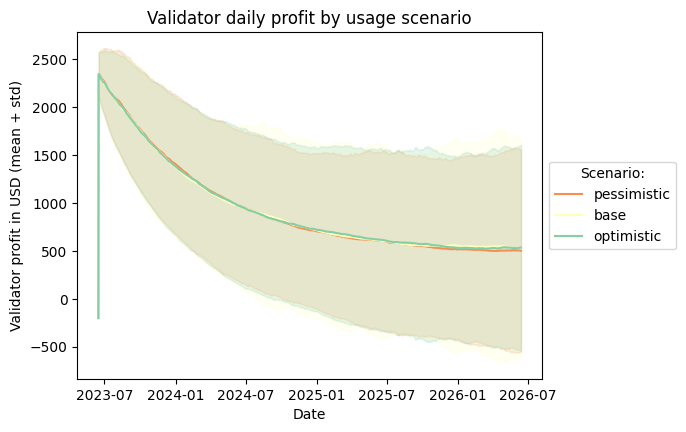

In [72]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="validator_profit", hue="usage_scenario", 
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Validator daily profit by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Validator profit in USD (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

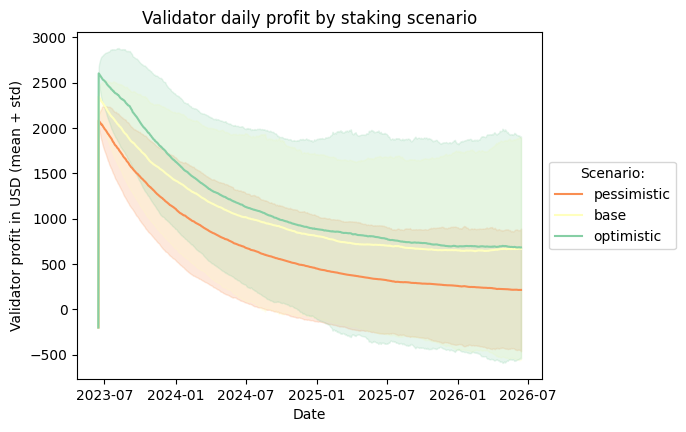

In [73]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="validator_profit", hue="staking_scenario", 
                   errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Validator daily profit by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("Validator profit in USD (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

In [74]:
df[df["iteration"]==1].groupby("staking_scenario")["validator_profit"].mean()

staking_scenario
base           2348.976837
optimistic     2603.499600
pessimistic    2083.487549
Name: validator_profit, dtype: float64

In [75]:
df[df["iteration"]==1092].groupby("staking_scenario")["validator_profit"].mean()

staking_scenario
base           668.302262
optimistic     684.315542
pessimistic    213.078346
Name: validator_profit, dtype: float64

## Ecosystem fund balance

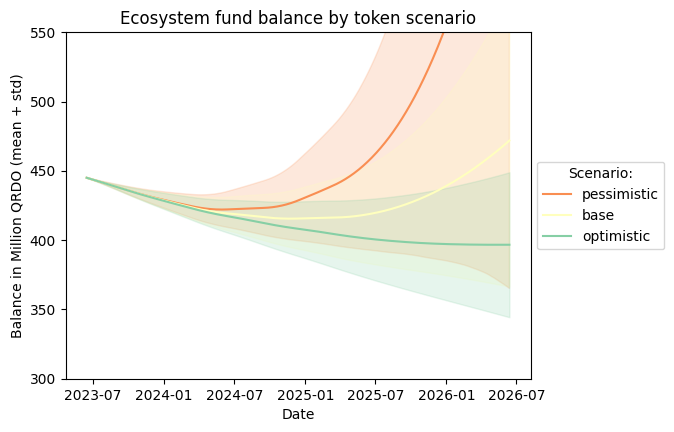

In [76]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="ecosystem_fund", hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(300,550)
plt.title("Ecosystem fund balance by token scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

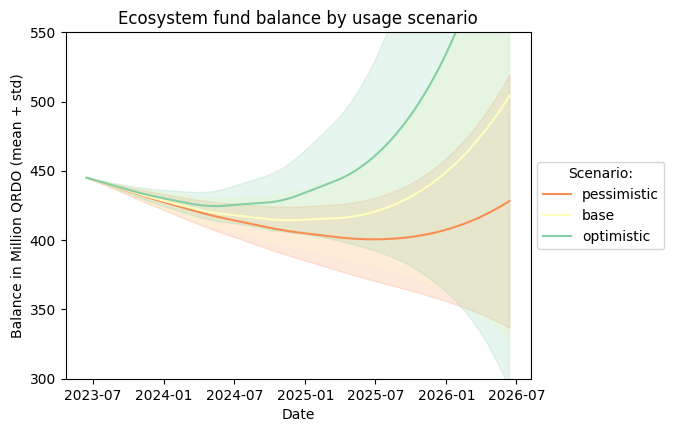

In [77]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="ecosystem_fund", hue="usage_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(300,550)
plt.title("Ecosystem fund balance by usage scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

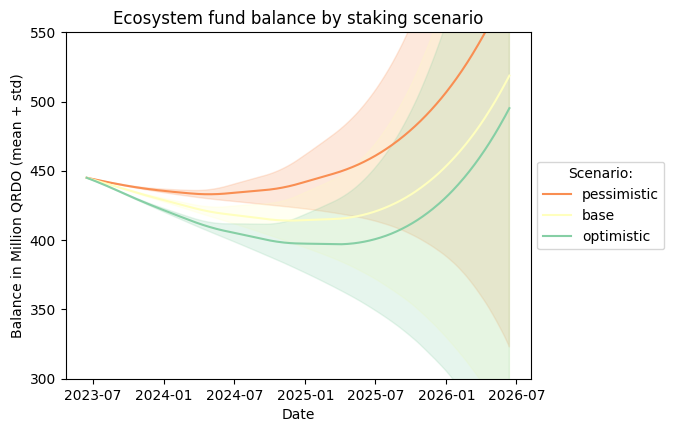

In [78]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=df, x="date", y="ecosystem_fund", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(300,550)
plt.title("Ecosystem fund balance by staking scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

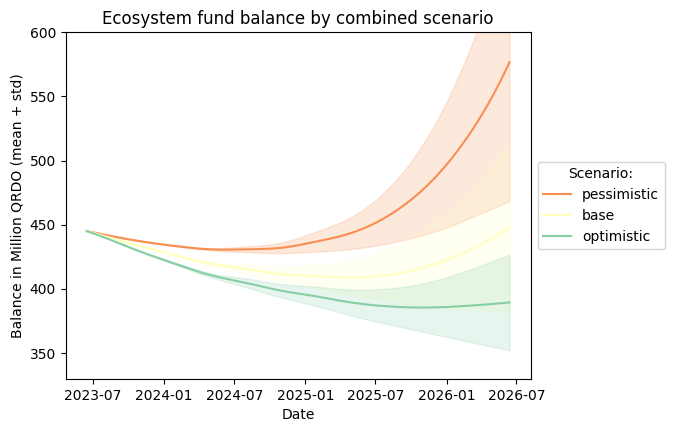

In [79]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df, x="date", y="ecosystem_fund", hue="staking_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.ylim(330,600)
plt.title("Ecosystem fund balance by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Balance in Million QRDO (mean + std)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Scenario:")
plt.show()

## Ecosystem fund net flows

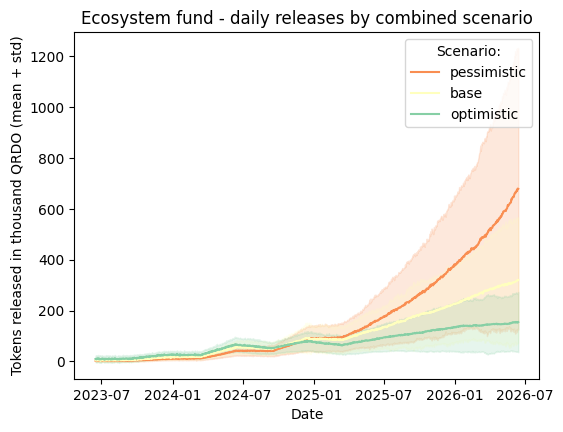

In [80]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df[combined_df["iteration"]>0], x="date", y="day_service_fee_locked", 
                   hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Ecosystem fund - daily releases by combined scenario") 
plt.xlabel("Date") 
plt.ylabel("Tokens released in thousand QRDO (mean + std)")
plt.legend(title="Scenario:")
plt.show()

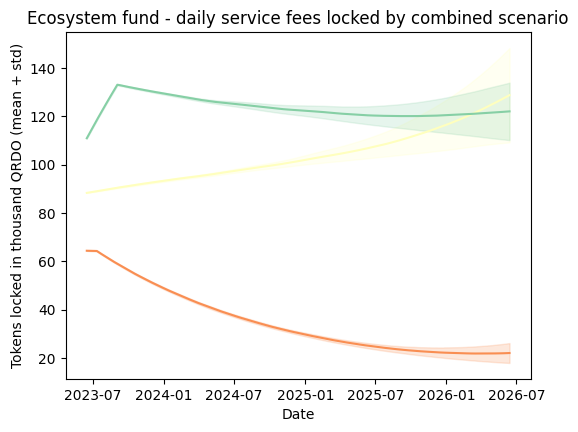

In [81]:
plt.figure(figsize=(6,4.5))
fig = sns.lineplot(data=combined_df[combined_df["iteration"]>0], x="date", y="staking_rewards_ecosystem", 
                   hue="token_scenario", errorbar="sd", palette="Spectral")
fig.xaxis.set_major_locator(mdates.MonthLocator(interval=month_int))
plt.title("Ecosystem fund - daily service fees locked by combined scenario")
plt.xlabel("Date") 
plt.ylabel("Tokens locked in thousand QRDO (mean + std)")
fig.get_legend().remove()
plt.show()